<a id = "table_of_contents"></a>
# Índice
[Objetivos del notebook](#objetivos)

[Importación de las principales librerías](#import_modules)

[Importación de los datos](#import_data)

[Exploratory Data Analysis (EDA)](#eda)

---> [EDA customers df](#df1)

---> [EDA orders df](#df2)

---> [EDA payments df](#df3)

[Creación de variables](#fe)

[Join final con clientes y variables finales](#join)

[Creación de nuestro Pipeline](#skpipeline)

[Elbow curve](#elbow_curve)

[Segmentación de los clientes con la "k adecuada"](#segmentacion)

[Modelo RFM](#rfm)

[Ficha de clientes](#ficha)

[Conclusión](#conclusión)

<a id = "objetivos"></a>
# Objetivos del notebook
[Volver al índice](#toc)

En este notebook vamos a trabajar con el dataset de la **compañia brasileña de E-Commerce llamada Olist.**

La compañia opera con una filosofía de ***SaaS (Software as a Service)***. Su producto básico es un marketplace donde tiendas **con o sin presencia online pueden vender sus productos a los clientes que visitan su web.**

![Data Model](https://i.imgur.com/HRhd2Y0.png)

Utilizando el dataset de Olist (alrededor de 100 mil registros) vamos a construir una segmentacion basada en el algoritmo KMeans. El enfoque a la hora de construir variables será basado en el modelo de ***RFM (recency - frequency - monetary value).*** Esta es una forma de trabajar muy común en startups y tiendas online donde se dispone de poca información de los clientes y la retención/canje de los clicks es fundamental.

Nuestros principales objetivos serán:
1. **Construir variables de negocio (pensadas para nuestra segmentación)** a partir de 3 datasets diferentes y juntarlos de forma correcta para no generar duplicidades de registros.



2. **Aprender a utilizar el Pipeline de sklearn** para agilizar mucho la transformación del dataset y la creación de variables.



3. **Aprender a implementar nuestros propios Transformers** que se puedan usar dentro de los Pipelines (por ejemplo para eliminar los outliers).



4. Usar el diagrama del codo para determinar la cantidad **"óptima"** de centroides para el modelo de KMeans.



5. **Resumir la información de nuestros clústers en un formato más amigable** usando Pandas (fichas de clientes).

<a id = "import_modules"></a>
# 1. Importación de las principales librerías
[Volver al índice](#table_of_contents)

In [11]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 175

In [19]:
PATH_FOLDER = "C:\\Users\\Jordi Grau\\Desktop\\Data Science Project\\KMeans_Olist\\KMeans_Olist\\olist_datasets"

<a id = "import_data"></a>
# 2. Importación de los datos
[Volver al índice](#table_of_contents)

In [21]:
PATH_CUSTOMERS = (PATH_FOLDER + '\\olist_customers_dataset.csv')

customer_df = pd.read_csv(PATH_CUSTOMERS)


In [22]:
PATH_ORDERS = os.path.join(PATH_FOLDER + '\\olist_orders_dataset.csv')

orders_df = pd.read_csv(PATH_ORDERS)

In [24]:
PATH_PAYMENTS = os.path.join(PATH_FOLDER + '\\olist_order_payments_dataset.csv')

payments_df = pd.read_csv(PATH_PAYMENTS)

<a id = "eda"></a>
# 3. Exploratory Data Analysis (EDA)
[Volver al índice](#table_of_contents)

En la sección del EDA haremos **una primera aproximación a nuestros datos** para ver su composición y que variables tenemos a nuestra disposición.

<a id = "df1"></a>
# 3.1. EDA customers df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de clientes.**

In [25]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [26]:
report_df(customer_df)

customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

Tenemos un total de 0 nulos


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [30]:
customer_id = customer_df['customer_id'].nunique()
customer_unique_id = customer_df['customer_unique_id'].nunique()

print(f'''Tenemos un total de {customer_unique_id} clientes únicos, \n
para un total de {customer_id} pedidos (en el esquema de Olist, especifican que customer_unique_id es el
id del cliente y customer_id es un id que se genera en cada compra).
Esto implicat que el ratio de pedidos por cliente es de {round(customer_id/customer_unique_id, 2)}.
''')

Tenemos un total de 96096 clientes únicos, 

para un total de 99441 pedidos (en el esquema de Olist, especifican que customer_unique_id es el
id del cliente y customer_id es un id que se genera en cada compra).
Esto implicat que el ratio de pedidos por cliente es de 1.03.



In [33]:
# create a groupby Dataframe by customer_city
city_pivot_ = customer_df.groupby(['customer_state', 'customer_city']).size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0:"clients_per_city"})

city_pivot_['cumsum_per_city'] = (city_pivot_['clients_per_city']/city_pivot_['clients_per_city'].sum()).cumsum()
city_pivot_['pct_city'] = (1/city_pivot_.shape[0])
city_pivot_['pct_city'] = city_pivot_['pct_city'].cumsum()

In [37]:
# create a groupby Dataframe by customer_state
state_pivot_ = customer_df.groupby('customer_state').size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0:"clients_per_state"})

state_pivot_['cumsum_per_state'] = (state_pivot_['clients_per_state']/state_pivot_['clients_per_state'].sum()).cumsum()

state_pivot_['pct_state'] = (1/state_pivot_.shape[0])
state_pivot_['pct_state'] = state_pivot_['pct_state'].cumsum()

Text(0.5, 0.98, 'Distribución acumulada de clientes por ciudad y estado (en absoluto y relativo)')

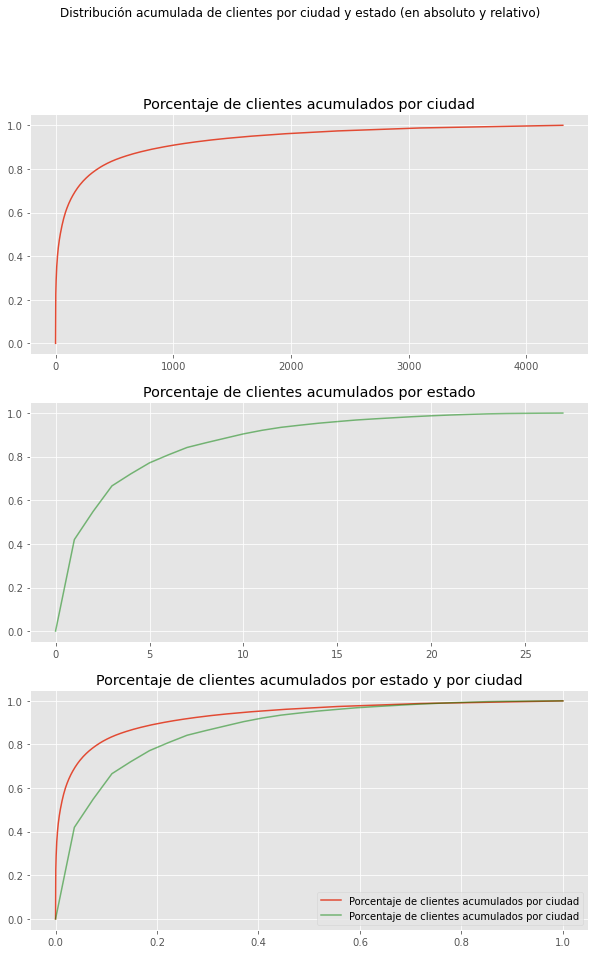

In [48]:
# Ploting part

# instanciate the figure
fig = plt.figure(figsize=(10, 15))
ax1, ax2, ax3 = fig.subplots(nrows = 3, ncols = 1)

x1_values = [0] + list(city_pivot_.index)
y1_values = [0] + list(city_pivot_["cumsum_per_city"])

x2_values = [0] + list(state_pivot_["cumsum_per_state"])
y2_values = [0] + list(state_pivot_["cumsum_per_state"])

x3_values_city = [0] + list(city_pivot_["pct_city"])
y3_values_city = [0] + list(city_pivot_["cumsum_per_city"])

x3_values_state = [0] + list(state_pivot_["pct_state"])
y3_values_state = [0] + list(state_pivot_["cumsum_per_state"])

# plot the values and set for every subplot a title
ax1.plot(y1_values)
ax1.title.set_text("Porcentaje de clientes acumulados por ciudad")

ax2.plot(y2_values, color = 'green', alpha = 0.5)
ax2.title.set_text("Porcentaje de clientes acumulados por estado")

ax3.plot(x3_values_city, y3_values_city, label = 'Porcentaje de clientes acumulados por ciudad')
ax3.plot(x3_values_state, y3_values_state, label = 'Porcentaje de clientes acumulados por ciudad',
        color = 'green', alpha = 0.5)
ax3.title.set_text('Porcentaje de clientes acumulados por estado y por ciudad')

ax3.legend()

# create a title for the subplots
fig.suptitle('Distribución acumulada de clientes por ciudad y estado (en absoluto y relativo)')

<a id = "df2"></a>
# 3.2. EDA orders df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pedidos.**

In [49]:
report_df(orders_df)

orders_df.head(3).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

Tenemos un total de 4908 nulos


,0,1,2
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089
order_status,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00


In [50]:
orders_df["order_status"].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [51]:
# tenemos nulls en las fechas, habrá o bien eliminar estos nulos o imputarles una fecha.
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [55]:
order_id = orders_df['order_id'].nunique()
customer_id_orders = orders_df['customer_id'].nunique()

# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
assert (set(orders_df["customer_id"]) ^ set(customer_df["customer_id"])) == set()
assert (set(customer_df["customer_id"]) ^ set(orders_df["customer_id"])) == set()

print(f"Tenemos un total de {order_id} pedidos")
print(f"Tenemos un total de {customer_unique_id} customer únicos (de la tabla de customers)")
print(f"La relación de pedidos por clientes es de {round(order_id/customer_unique_id, 2)}")

Tenemos un total de 99441 pedidos
Tenemos un total de 96096 customer únicos (de la tabla de customers)
La relación de pedidos por clientes es de 1.03


<a id = "df3"></a>
# 3.3. EDA payments df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pagos.**

In [56]:
report_df(payments_df)

payments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None

Tenemos un total de 0 nulos


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


<AxesSubplot:>

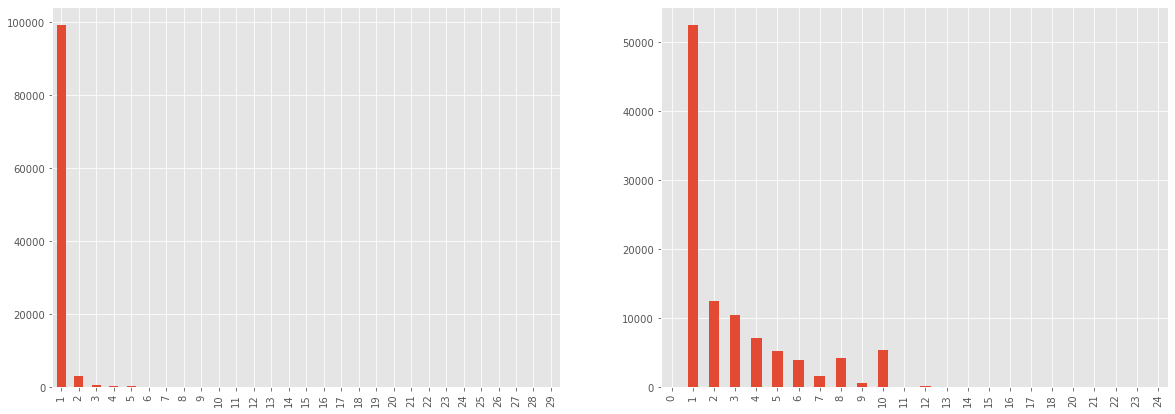

In [60]:
fig = plt.figure(figsize=(20, 7))
ax1, ax2 = fig.subplots(1, 2)

payments_df['payment_sequential'].value_counts().sort_index().plot(kind = 'bar', ax = ax1)
payments_df['payment_installments'].value_counts().sort_index().plot(kind = 'bar', ax = ax2)

In [61]:
payments_df['payment_sequential'].value_counts()

1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
18        6
19        6
16        6
17        6
21        4
20        4
22        3
26        2
24        2
23        2
25        2
29        1
28        1
27        1
Name: payment_sequential, dtype: int64

In [62]:
order_id_pay = payments_df['order_id'].nunique()
print(f'Tenemos un total de {order_id_pay} pedidos únicos en la tabla de payments')

Tenemos un total de 99440 pedidos únicos en la tabla de payments


In [63]:
# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
len(set(orders_df["order_id"]))

99441

In [64]:
set(orders_df["order_id"]) ^ set(payments_df["order_id"])

{'bfbd0f9bdef84302105ad712db648a6c'}

In [65]:
orders_df[orders_df["order_id"] == "bfbd0f9bdef84302105ad712db648a6c"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00


In [66]:
payments_df['order_id'].value_counts()

fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
fedcd9f7ccdc8cba3a18defedd1a5547    19
                                    ..
6d2a30c9b7dcee3ed507dc9a601f99e7     1
a7737f6d9208dd56ea498a322ed3c37f     1
646e62df54f3e236eb6d5ff3b31429b8     1
e115da7a49ec2acf622e1f31da65cfb9     1
28bbae6599b09d39ca406b747b6632b1     1
Name: order_id, Length: 99440, dtype: int64

In [67]:
order_id_ = 'fa65dad1b0e818e3ccc5cb0e39231352'

In [71]:
payments_df.groupby('order_id').get_group((order_id_)).sort_values(by='payment_sequential')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
82593,fa65dad1b0e818e3ccc5cb0e39231352,7,voucher,1,0.32
68853,fa65dad1b0e818e3ccc5cb0e39231352,8,voucher,1,26.02
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86
